In [35]:
pip install implicit==0.4.8

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.metrics import precision_at_k, recall_at_k

### Знакомимся с данными, изучаем их и смотрим.

In [2]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

In [3]:
data.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [5]:
item_features.head(5)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [6]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [7]:
user_features.head(5)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [8]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


### Работа с данными и их подготовка.

In [9]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [10]:
from src.utils import prefilter_items

In [11]:
prefilter_items(data, take_n_popular=5000, item_features=None)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
3,2375,26984851472,1,999999,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0,1.57
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396798,1613,41655820646,663,999999,1,2.99,3262,-0.16,1231,95,0.0,0.0,2.99
2396799,1613,41655820646,663,999999,1,2.00,3262,-1.15,1231,95,0.0,0.0,2.00
2396800,1001,41655829421,663,999999,1,1.69,3131,0.00,2231,95,0.0,0.0,1.69
2396801,1001,41655829421,663,999999,1,1.69,3131,0.00,2231,95,0.0,0.0,1.69


In [12]:
val_lvl_1_size_weeks = 6 # Выберем период 6 недель
val_lvl_2_size_weeks = 3 # Выберем период 3 недели

In [13]:
data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=10000)

### Строим первую модель и ее обучаем.

In [14]:
from src.recommenders import MainRecommender # код этого класса продублирован ниже

In [15]:
class MainRecommender:
    """Рекоммендации, которые можно получить из ALS
    
    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """
    
    def __init__(self, data, weighting=True):
        
        # your_code. Это не обязательная часть. Но если вам удобно что-либо посчитать тут - можно это сделать
        self.data = data.copy()
        self.popularity = self.data.groupby('item_id')['quantity'].sum().reset_index()
        self.popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
        self.popularity = self.popularity.sort_values('n_sold', ascending=False).item_id.tolist()		
        
        self.user_item_matrix = self.prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid,\
            self.itemid_to_id, self.userid_to_id = self.prepare_dicts(self.user_item_matrix)
        
        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T 
        
        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
     
    @staticmethod
    def prepare_data(data, val_lvl_1_size_weeks = 6, val_lvl_2_size_weeks = 3):       
        data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
        data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                              (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

        data_train_lvl_2 = data_val_lvl_1.copy() 
        data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

        return data_train_lvl_1, data_val_lvl_1, data_train_lvl_2, data_val_lvl_2
    
    @staticmethod
    def prepare_matrix(data):
        
        # your_code
        user_item_matrix = pd.pivot_table(data=data, 
                                          index='user_id', columns='item_id', 
                                          values='quantity', # Можно пробовать другие варианты
                                          aggfunc='count', 
                                          fill_value=0)
        
        user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
        
        return user_item_matrix
    
    @staticmethod
    def prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""
        
        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))
        
        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id
     
    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""
    
        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())
        
        return own_recommender
    
    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        """Обучает ALS"""
        
        model = AlternatingLeastSquares(factors=n_factors, 
                                             regularization=regularization,
                                             iterations=iterations,  
                                             num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())
        
        return model    

    def get_als_recommendations(self, user, N=5):

        filter_items = [self.itemid_to_id[999999]]
        if user not in self.userid_to_id.keys():
            return self.popularity[:N]

        # your_code
        sparse_user_item=csr_matrix(self.user_item_matrix).tocsr()
        
        res = [self.id_to_itemid[rec[0]] for rec in 
                    self.model.recommend(userid=self.userid_to_id[user], 
                                         user_items=sparse_user_item,   # на вход user-item matrix
                                         N=N, 
                                         filter_already_liked_items=False, 
                                         filter_items=filter_items,
                                         recalculate_user=True)]
        if len(res) < N:
            res = np.append(res, self.popularity[:(N - len(res))])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        if user not in self.userid_to_id.keys():
            return self.popularity[:N]

        filter_items = [self.itemid_to_id[999999]]

        # your_code
        sparse_user_item=csr_matrix(self.user_item_matrix).tocsr()
        
        res = [self.id_to_itemid[rec[0]] for rec in 
                    self.own_recommender.recommend(userid=self.userid_to_id[user], 
                                         user_items=sparse_user_item,   # на вход user-item matrix
                                         N=N, 
                                         filter_already_liked_items=False, 
                                         filter_items=filter_items,
                                         recalculate_user=True)]
 
        if len(res) < N:
            res = np.append(res, self.popularity[:(N - len(res))])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [16]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

In [17]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual'], k=50), axis=1).mean()

0.056345944150348395

### Подготовка тестового датасета

In [18]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [19]:
targets_lvl_2.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69.0,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,834103,1.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,834103,1.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,834103,1.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,834103,1.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


### Добавляем новые фичи (Средний чек пользователя, сумма его покупки; для товаров: цена, среднее количество продаж товара)

In [20]:
def new_features(target_df, df):

    average_check = df.groupby(['user_id', 'basket_id'], as_index=False)['sales_value'].sum()
    average_check = average_check.groupby('user_id', as_index=False).mean()
    average_check = average_check.drop('basket_id', axis=1)
    average_check.rename(columns={'sales_value': 'average_check'}, inplace=True)
    target_df = target_df.merge(average_check, on='user_id', how='left')
    
    num_pur = df.merge(item_features, on='item_id', how='left')
    num_pur = num_pur.groupby(['user_id', 'department'], as_index=False)['quantity'].sum()
    num_pur.rename(columns={'quantity': 'num_pur'}, inplace=True)
    num_pur['num_pur'].fillna(0, inplace=True)
    target_df = target_df.merge(num_pur, on=['user_id', 'department'], how='left')
    
    price = df.loc[:,('item_id', 'quantity', 'sales_value')]
    price = price.groupby('item_id', as_index=False)[['quantity', 'sales_value']].sum()
    price['price'] = price['sales_value'] / price['quantity']
    price = price.drop(['quantity', 'sales_value'], axis=1)
    target_df = target_df.merge(price, on='item_id', how='left')
    
    average_number_product  = df.groupby(['item_id'])['quantity'].count().reset_index()
    average_number_product.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
    average_number_product['quantity_of_sales_per_week'] = average_number_product['quantity_of_sales'] / df['week_no'].nunique()
    target_df = target_df.merge(average_number_product, on='item_id')
    
    return(target_df)

In [21]:
targets_lvl_2 = new_features(targets_lvl_2, data_train_lvl_2)

### Фильруем данные.

In [22]:
import missingno as msno # Для этого используем библиотеку, которая визуализирует гистограмму с пропущенными значениями.

<AxesSubplot:>

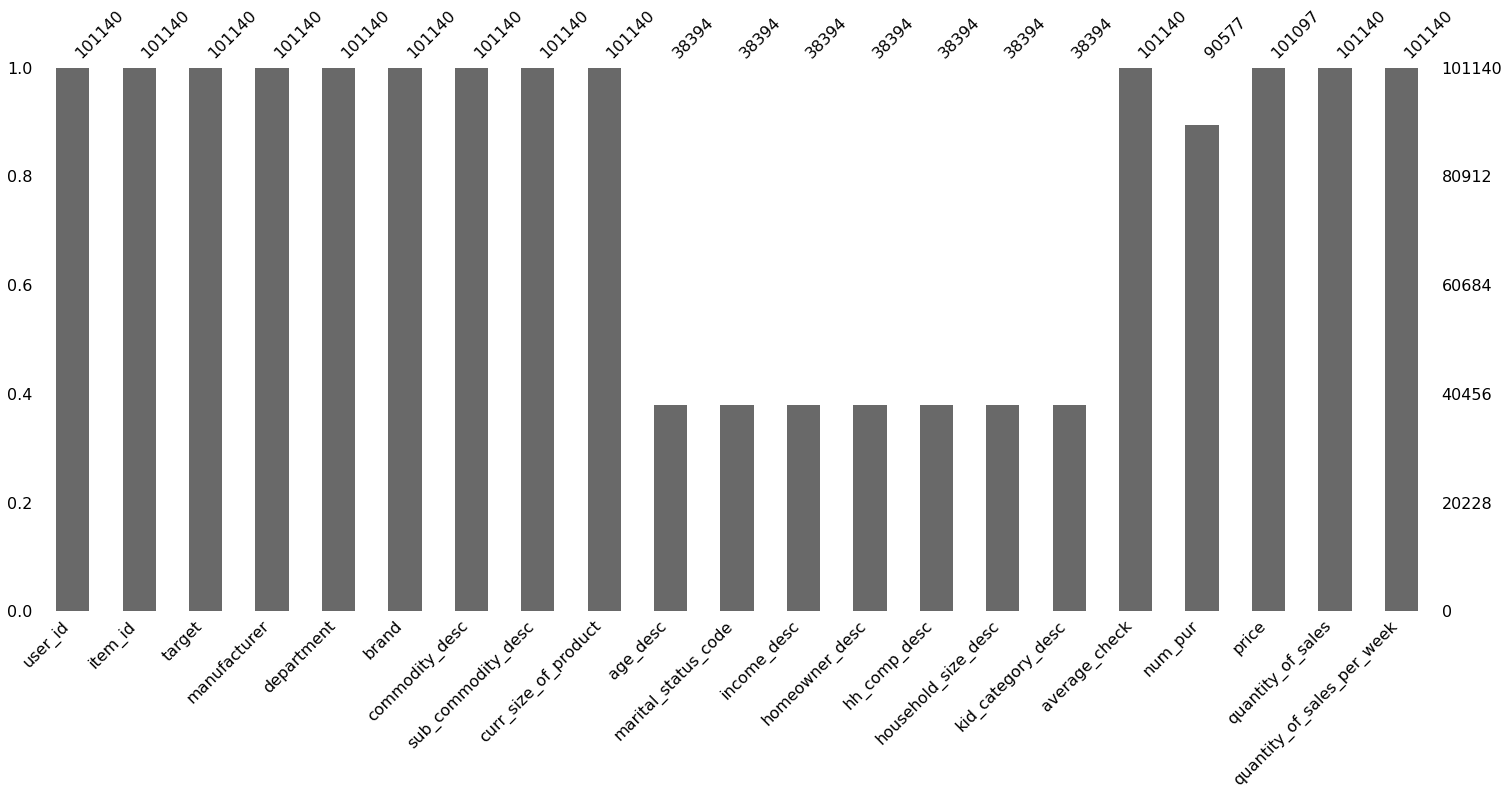

In [23]:
msno.bar(targets_lvl_2)

### Видим что, семь столбоцов: 'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc','kid_category_desc', имеют много пропусков. Отбрасываем их.

In [24]:
targets_lvl_2.drop(['age_desc', 
                     "marital_status_code", 
                     'income_desc', 
                     'homeowner_desc', 
                     'hh_comp_desc', 
                     'household_size_desc',
                     'kid_category_desc'],
                    axis=1,
                    inplace=True)

In [25]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [26]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

### Обучаем второй уровень

In [35]:
import lightgbm as lgb

dtrain = lgb.Dataset(data=X_train, label=y_train, categorical_feature=cat_feats)

params = {
            "boosting_type": "goss",
            "objective": "binary",
            "metric": "auc",
            "learning_rate": 0.01,
            "n_jobs": 6,
            "seed": 27
         }
        
model_lgb = lgb.train(
                      params=params,
                      train_set=dtrain,
                      num_boost_round=6000,
                      valid_sets=[dtrain],
                      categorical_feature="auto",
                      early_stopping_rounds=20,
                      verbose_eval=100
                     )

[LightGBM] [Info] Number of positive: 13426, number of negative: 87714
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8533
[LightGBM] [Info] Number of data points in the train set: 101140, number of used features: 13
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.132747 -> initscore=-1.876888
[LightGBM] [Info] Start training from score -1.876888
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.889669
[200]	training's auc: 0.903306
[300]	training's auc: 0.914218
[400]	training's auc: 0.922532
[500]	training's auc: 0.929209
[600]	training's auc: 0.934945
[700]	training's auc: 0.940193
[800]	training's auc: 0.944935
[900]	training's auc: 0.949194
[1000]	training's auc: 0.953039
[1100]	training's auc: 0.956539
[1200]	training's auc: 0.959793
[1300]	training's auc: 0.962724
[1400

In [36]:
predictions = model_lgb.predict(X_train)

In [37]:
targets_lvl_2['predictions'] = predictions
targets_lvl_2 = targets_lvl_2.sort_values(['user_id', 'predictions'], ascending=[False, False])

In [38]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(5)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [39]:
predictions_lgbm = targets_lvl_2[['user_id', 'item_id']].copy().drop_duplicates()
predictions_lgbm = predictions_lgbm.groupby('user_id')['item_id'].apply(list).reset_index()
predictions_lgbm['item_id'] = predictions_lgbm.apply(lambda row: row['item_id'][:5], axis=1)

In [40]:
result = result.merge(predictions_lgbm, on='user_id', how='left')
result.rename(columns={'item_id': 'lgb'}, inplace=True)

In [42]:
result = result[result['lgb'].notna()]

In [43]:
result.head(5)

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8293439, 9655212, 9527558, 5577022, 1049998]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[895268, 897088, 12757544, 13115971, 1041259]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[9338009, 840386, 9527174, 993838, 983316]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[8181377, 8159536, 1021715, 930385, 983795]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[12171886, 12172071, 8019977, 868015, 907647]"


In [58]:
def prediction_user(id_user):
    rec_als = recommender.get_als_recommendations(id_user, N=150)
    
    df=pd.DataFrame({'item_id':rec_als})
    df['user_id'] = id_user
    
    df = df.merge(item_features, on='item_id', how='left')
    df = df.merge(user_features, on='user_id', how='left')
    
    df = new_features(df, data_train_lvl_2)
    
    df[cat_feats] = df[cat_feats].astype('category')
    preds = model_lgb.predict(df)
    
    df['pred'] = preds
    df = df.sort_values(['user_id', 'pred'], ascending=[False, False])
    
    return df['item_id'].to_list()[:5]

In [53]:
result.loc[result['lgb'].isna(), 'lgb'] = result.loc[result['lgb'].isna(), 'user_id'].apply(lambda x: prediction_user(x))

In [54]:
result.apply(lambda row: precision_at_k(row['lgb'], row['actual'], k=5), axis=1).mean()

0.2354046997389016

### Минимальный порог скора превышен

In [55]:
result.drop(['actual'], axis=1, inplace=True)

In [59]:
result.to_csv('recommendations.csv')